In [9]:
import pymongo
from sklearn.preprocessing import StandardScaler
import datetime 
from collections import defaultdict
class Database(object):
    def __init__(self):
        self.connection = pymongo.MongoClient("localhost", 27017)
        self.db = self.connection["DSS4_SmallP"]
        self.mov = self.db["Movie_mojo"]
        self.act = self.db["actor"]
        self.dir = self.db['director']
        self.fra = self.db['franchise']
        
def get_score(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)

    score = 0
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        score += name[mov][3]
    return score
def get_score_avg(name, idt, year):
    idt = idt.split('/')
    idt = datetime.date(int(idt[2])+2000, int(idt[0]), int(idt[1]))
    ytd = datetime.timedelta(days = 365*year)
    count = 0.
    score = 0.
    for mov in name :
  #      print(mov)
        if len(name[mov]) == 4 :
            if name[mov][2] != 'NA':
                mdt = name[mov][2].split('/')
                mdt = datetime.date(int(mdt[2])+2000, int(mdt[0]), int(mdt[1]))
                if idt - mdt < ytd and datetime.timedelta(0) < idt - mdt:
                    if name[mov][3] != 'NA' :
                        count += 1.
                        score += name[mov][3]
    if count != 0 : return score/count
    else : return 0


db = Database()

In [2]:
dict_act = {}
actors = db.act.find()
for act in actors:
    dict_act[act['name']] = act['movie']
dict_dir = {}
directors = db.dir.find()
for dire in directors:
    dict_dir[dire['name']] = dire['movie']
dict_fra = {}
franchise = db.fra.find()
for fra in franchise:
    dict_fra[fra['name']] = fra['movie']

In [15]:
#arr_col = ['Mname','nation','project_budget','genre','grade','release_kor','viewing_time','year']
arr_col = ['Mname','director','franchise','release_kor','grade',
           'project_budget','actor','grade','release_kor','viewing_time',
           'year','genre','nation', 'gross_us', 'gross_kor']
movies = db.mov.find({'gross_us' : {'$exists' : 'True'}})
data = [] 
for n, line in enumerate(movies):
    movie = defaultdict(lambda: list())
    for key in arr_col :
        if (line[key] == 'NA') or (line[key] == -1):
            line[key] = np.nan
        movie[key] = line[key]
    if type(movie['nation']) == 'list' and u'한국' in movie['nation'] :
        pass
    else :
        score_act = 0
        score_dir = 0
        score_fra = 0
        for it in movie['actor']:
            score_act += get_score_avg(dict_act[it], movie['release_kor'], 5)
        for it in movie['director']:
            score_dir += get_score_avg(dict_dir[it], movie['release_kor'], 5)
        for it in movie['franchise']:
            score_fra += get_score_avg(dict_fra[it], movie['release_kor'], 5)
        movie['score_act'] = score_act
        movie['score_dir'] = score_dir
        movie['score_fra'] = score_fra
        data.append(movie)
df = pd.DataFrame(data)
df.score_act = df.score_act.replace(0,np.nan)
df.score_dir = df.score_dir.replace(0,np.nan)

In [16]:
dfn = df.dropna()
dfn = dfn.reset_index(drop = 1)

In [17]:
season_dum = pd.DataFrame(np.zeros((len(dfn), 5)),columns = ['sp_d','su_d','au_d','wi_d','season'])
for i, mon in enumerate(dfn.release_kor):
    mon = int(mon.split('/')[0])
    if 3 <= mon < 6 :
        season_dum.ix[i, 0] = 1
        season_dum.ix[i, 4] = 0
    elif 6 <= mon < 9 :
        season_dum.ix[i, 1] = 1
        season_dum.ix[i, 4] = 1
    elif 9 <= mon < 12 :
        season_dum.ix[i, 2] = 1
        season_dum.ix[i, 4] = 2
    else :
        season_dum.ix[i, 3] = 1
        season_dum.ix[i, 4] = 3
dfn = dfn.join(season_dum)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'NanumGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


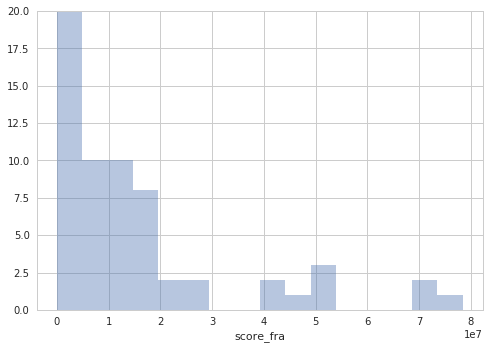

In [18]:
sns.distplot(dfn['score_fra'], kde = 0)
plt.ylim(0,20)
plt.show()

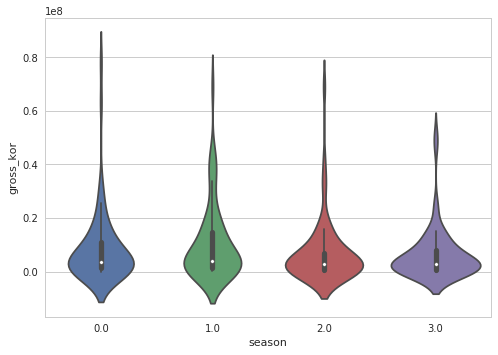

In [19]:
sns.violinplot(y = dfn['gross_kor'], x = dfn['season'])
plt.show()

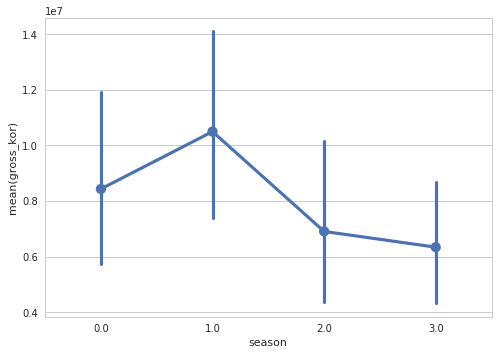

In [20]:
sns.pointplot(x="season", y="gross_kor",  data=dfn, dodge=True)
plt.show()

In [21]:
#장르 더미
genre = [u'\uac00\uc871',
 u'\uc2dc\ub300\uadf9',
 u'\uc2a4\ub9b4\ub7ec',
 u'\ub4dc\ub77c\ub9c8',
 u'\uc560\ub2c8\uba54\uc774\uc158',
 u'\uc804\uc7c1',
 u'\uc5b4\ub4dc\ubca4\ucc98',
 u'\uacf5\ud3ec',
 u'\ud310\ud0c0\uc9c0',
 u'\ubbf8\uc2a4\ud130\ub9ac',
 u'\ub2e4\ud050\uba58\ud130\ub9ac',
 u'\uc11c\ubd80',
 u'\ub85c\ub9e8\uc2a4/\uba5c\ub85c',
 u'\uc561\uc158',
 u'\ubc94\uc8c4',
 u'\ucf54\ubbf8\ub514',
 u'\ubb34\ud611',
 u'SF',
 u'\ubba4\uc9c0\uceec']
dummies = pd.DataFrame(np.zeros((len(dfn), len(genre))), columns=genre)
for i, gen in enumerate(dfn.genre):
    for j in gen:
        dummies.ix[i, j] = 1./len(gen)
gen = np.arange(len(genre))
dummies.columns = gen
dfn = dfn.join(dummies.add_prefix('Genre_'))

In [22]:
#등급 더미
dfgrade = pd.get_dummies(dfn.grade)
del dfgrade[u'']
dfgrade.columns = [12,15,0,18]
dfn = dfn.join(dfgrade)

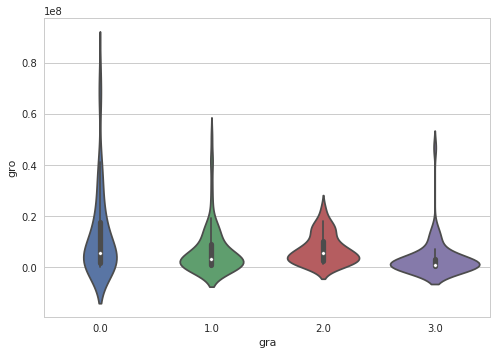

In [23]:
#등급 바이올린 플롯
grades = [u'12세이상관람가', u'15세이상관람가', u'전체관람가', u'청소년관람불가']
dfg2 = pd.DataFrame(np.zeros((len(dfn), 2)), columns=['gra', 'gro'])
for n, gra in enumerate(dfn.grade) :
    if gra != u'':
        idg = grades.index(gra)
        dfg2.ix[n, 'gra'] = idg
        dfg2.ix[n, 'gro'] = dfn.ix[n,'gross_kor']
sns.violinplot(y = dfg2['gro'], x = dfg2['gra'])
plt.show()

In [24]:
#장르 바이올린 플롯
dfgen = pd.DataFrame(np.zeros((len(dfn), 2)), columns=['genre','gross_kor'])
count = 0
for i, gen in enumerate(dfn.genre):
    for j in gen:
        sel = genre.index(j)
        dfgen.ix[count,'genre'] = sel
        dfgen.ix[count,'gross_kor'] = dfn.ix[i,'gross_kor']
        count += 1

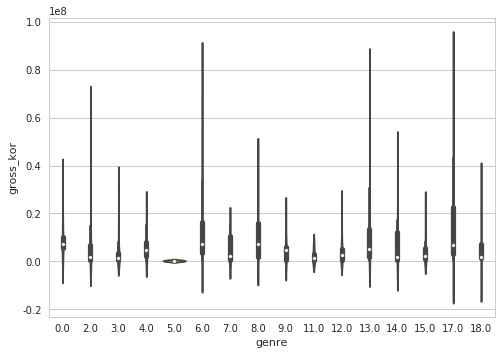

In [25]:
sns.violinplot(y = dfgen['gross_kor'], x = dfgen['genre'])
plt.show()

In [26]:
df_n0 = dfn[dfn['score_dir']!=0].reset_index(drop = 1)
df_n0 = df_n0[df_n0['score_act']!=0].reset_index(drop = 1)

In [92]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

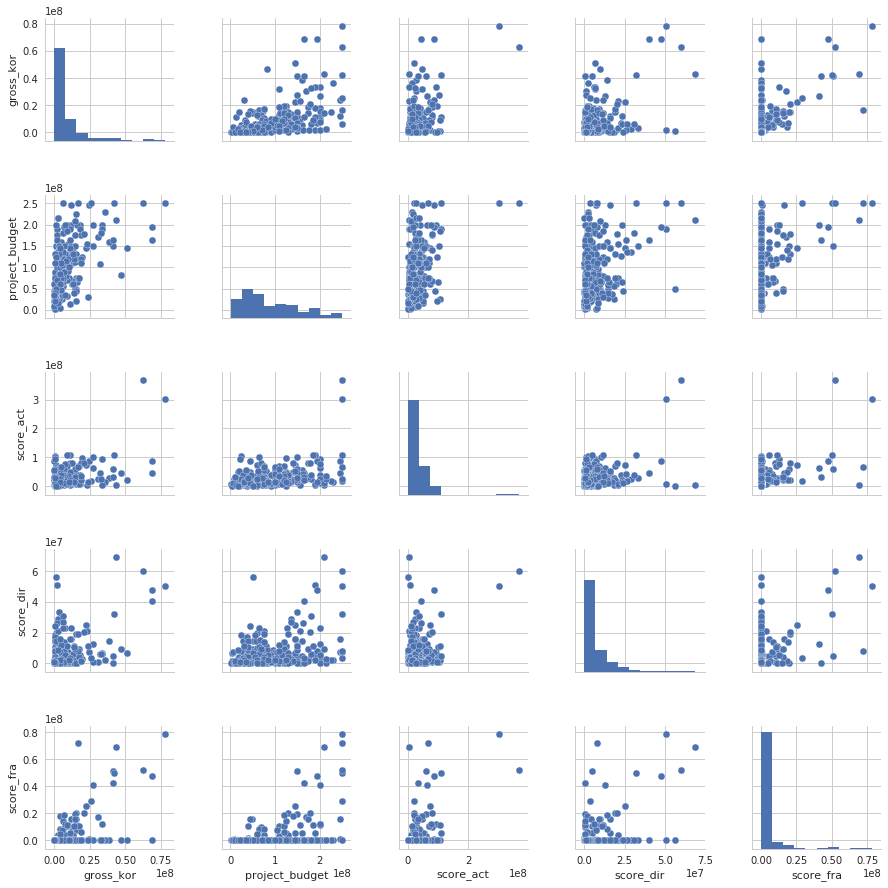

In [28]:
sns.pairplot(dfn, vars=['gross_kor', 'project_budget', 'score_act', 'score_dir', 'score_fra'])
plt.tight_layout()
plt.show()

In [109]:
dfx = sm.add_constant(dfx, has_constant='add')
dfx.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

In [110]:
model = sm.OLS( dfy['gross_kor'], dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     9.333
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           4.54e-24
Time:                        14:40:06   Log-Likelihood:                -422.24
No. Observations:                 265   AIC:                             898.5
Df Residuals:                     238   BIC:                             995.1
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              8.4535      1.441      5.

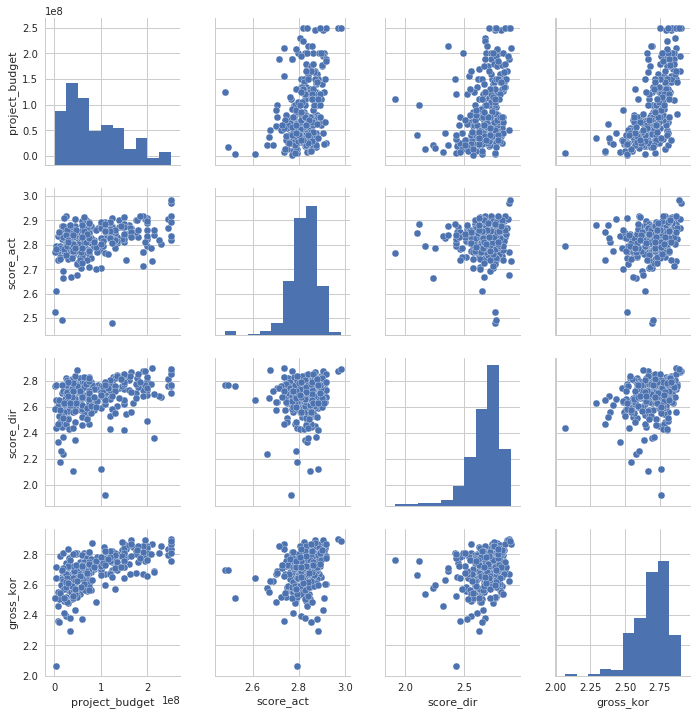

In [111]:
#로그변환
#dfx['log_bud'] = np.log(dfx['project_budget'])
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfy = np.log(dfy)
#del dfx['project_budget']
#del dfx['score_act']
#del dfx['score_dir']
sns.pairplot(dfx.join(dfy), vars=['project_budget', 'score_act', 'score_dir','gross_kor'])
plt.show()

In [112]:
model = sm.OLS( dfy['gross_kor'], dfx)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     8.423
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           1.00e-21
Time:                        14:40:15   Log-Likelihood:                 271.07
No. Observations:                 265   AIC:                            -488.1
Df Residuals:                     238   BIC:                            -391.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              1.6807      0.239      7.

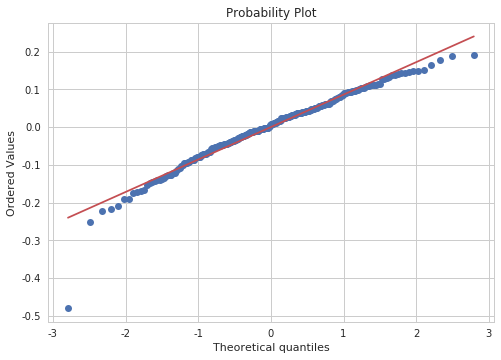

In [113]:
#아웃라이어
plt.figure()
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [114]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(dfx)-2)
idx = np.where(cooks_d2 < fox_cr)[0]
dfx2 = dfx.reset_index(drop = 1).ix[idx,:]
dfy2 = dfy.reset_index(drop = 1).ix[idx, :]

In [115]:
model2 = sm.OLS(dfy2['gross_kor'], dfx2)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     9.966
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           5.00e-24
Time:                        14:40:26   Log-Likelihood:                 291.50
No. Observations:                 250   AIC:                            -533.0
Df Residuals:                     225   BIC:                            -445.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const              1.3149      0.172      7.

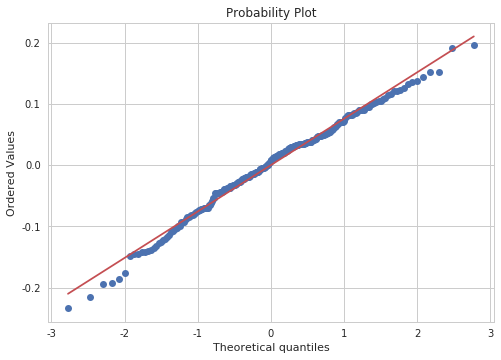

In [116]:
plt.figure()
sp.stats.probplot(result2.resid, plot = plt)
plt.show()

In [301]:
dfx2.columns

Index([         u'const', u'project_budget',      u'score_act',
            u'score_dir',      u'score_fra',        u'Genre_0',
              u'Genre_1',        u'Genre_2',        u'Genre_3',
              u'Genre_4',        u'Genre_5',        u'Genre_6',
              u'Genre_7',        u'Genre_8',        u'Genre_9',
             u'Genre_10',       u'Genre_11',       u'Genre_12',
             u'Genre_13',       u'Genre_14',       u'Genre_15',
             u'Genre_16',       u'Genre_17',       u'Genre_18',
                 u'sp_d',           u'su_d',           u'au_d',
                 u'wi_d',                 0,                12,
                      15,                18],
      dtype='object')

In [117]:
#스케일링
scaler = StandardScaler()
df3 = pd.DataFrame(scaler.fit_transform(dfx2.ix[:, 1:5]), columns=dfx2.columns[1:5])

In [118]:
df3 = df3.join(dfx2.reset_index(drop=1).ix[:,5:-8])


In [119]:
model3 = sm.OLS(dfy2.reset_index(drop = 1), df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     12.15
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           1.40e-24
Time:                        14:41:18   Log-Likelihood:                 284.22
No. Observations:                 250   AIC:                            -530.4
Df Residuals:                     231   BIC:                            -463.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
project_budget     0.0528      0.008      6.

In [120]:
#변수선택
del df3['Genre_0']
del df3['Genre_5']
del df3['Genre_10']
del df3['Genre_11']
del df3['Genre_16']
del df3['Genre_18']
del df3['score_dir']
del df3['score_act']

In [121]:
model3 = sm.OLS(dfy2.reset_index(drop = 1), df3)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2520.
Date:                Fri, 03 Mar 2017   Prob (F-statistic):          4.78e-248
Time:                        14:41:25   Log-Likelihood:                 23.622
No. Observations:                 250   AIC:                            -19.24
Df Residuals:                     236   BIC:                             30.06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
project_budget     0.0599      0.020      2.

In [172]:
dfx = pd.DataFrame(df_n0, columns= [ u'project_budget', u'score_act', u'score_dir', u'score_fra',
    u'Genre_0', u'Genre_1', u'Genre_2', u'Genre_3', u'Genre_4', u'Genre_5', u'Genre_6',
    u'Genre_7', u'Genre_8', u'Genre_9', u'Genre_10', u'Genre_11', u'Genre_12',
    u'Genre_13', u'Genre_14', u'Genre_15', u'Genre_16', u'Genre_17', u'Genre_18',
                                    'sp_d','su_d','au_d','wi_d',0,12,15,18])
dfy = pd.DataFrame(df_n0, columns = ['gross_kor'])

In [173]:
#Y값을 제작비 대비 매출로.
dfy_r = pd.DataFrame(dfy['gross_kor'] / dfx['project_budget'], columns=['ratio'])
del dfx['project_budget']

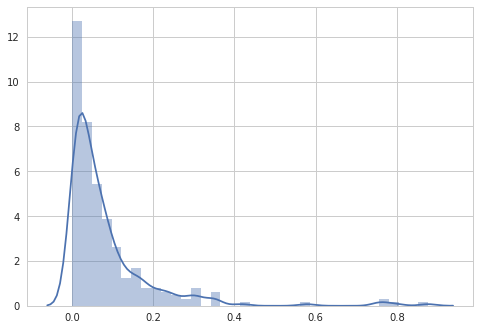

In [174]:
sns.distplot(dfy_r)
plt.show()

In [175]:
dfy_r = dfy_r.dropna()

In [176]:
model3 = sm.OLS(dfy_r, dfx)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     2.595
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           0.000102
Time:                        14:54:09   Log-Likelihood:                 212.26
No. Observations:                 265   AIC:                            -372.5
Df Residuals:                     239   BIC:                            -279.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act   1.209e-10   2.44e-10      0.496      0.6

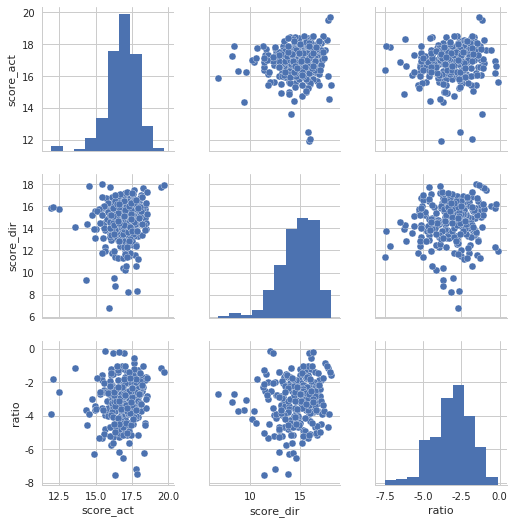

In [177]:
#로그변환
#dfx['log_bud'] = np.log(dfx['project_budget'])
dfx['score_act'] = np.log(dfx['score_act'])
dfx['score_dir'] = np.log(dfx['score_dir'])
dfy_r = np.log(dfy_r)
#del dfx['project_budget']
#del dfx['score_act']
#del dfx['score_dir']
sns.pairplot(dfx.join(dfy_r), vars=['score_act', 'score_dir','ratio'])
plt.show()

In [178]:
model3 = sm.OLS(dfy_r, dfx)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2.731
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           4.17e-05
Time:                        14:54:46   Log-Likelihood:                -412.93
No. Observations:                 265   AIC:                             877.9
Df Residuals:                     239   BIC:                             970.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act      0.0206      0.079      0.260      0.7

In [183]:
dfx2 = pd.DataFrame(scaler.fit_transform(dfx.ix[:, 0:3]), columns=dfx.columns[0:3])
dfy2 = pd.DataFrame(scaler.fit_transform(dfy), columns=dfy.columns)

In [185]:
dfx2 = dfx2.join(dfx.reset_index(drop=1).ix[:,3:])

In [188]:
model3 = sm.OLS(dfy2, dfx2)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:              gross_kor   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     9.067
Date:                Fri, 03 Mar 2017   Prob (F-statistic):           6.89e-23
Time:                        14:59:41   Log-Likelihood:                -287.64
No. Observations:                 265   AIC:                             627.3
Df Residuals:                     239   BIC:                             720.3
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
score_act      0.1210      0.051      2.362      0.0

In [ ]:
del dfx2[]
del dfx2[]
del dfx2[]
del dfx2[]
del dfx2[]
del dfx2[]